# Optimizing wait-times in the outpatient department using machine learning. Case of PSMI hospitals.

## 1 Problem Statement

The Institute of Medicine (IOM) has set a benchmark, recommending that a minimum of 90% of patients should be attended to within a 30-minute window from their scheduled appointment time (Usman, Saheed Opeyemi, 2020). However, despite this guideline, the current average waiting time at Premier Services Medical Investments (PSMI) stands at 42 minutes, surpassing the established standards. This discrepancy between the recommended waiting time and the actual waiting time experienced by patients highlights a significant challenge within the healthcare system. It suggests potential inefficiencies in scheduling, resource allocation, or patient flow management at PSMI, which could adversely impact patient satisfaction, operational efficiency, and overall quality of care. This challenge caused clients to cancel their subscriptions with PSMI, joining other alternatives in the industry. From the financial statements of the company, there was an annual decline in revenue by 28% between 2023 and 2024 which resulted in high staff turnover. Addressing this issue is crucial for PSMI to align with best practices, enhance patient experience, and optimize their healthcare delivery processes.

## 2 Data Description

| Feature Name                      |  Feature Description                                                  
| --------------------------------  | -------------------------------------------------------------------- 
| 1. RecordId                       | System generated ID
| 2. Region                         | City where the clinic or hospital is located 
| 3. Branch                         | The hospital or clinic to which the entry belongs
| 4. PatientId                      | Identification of a patient                                          
| 5. Sex                            | Male or Female.                                                      
| 6. Age                            | How old is the patient.
| 7. Had appointment                | True or False. Indicates if the patient had booked an appointment prior to the visit
| 8. p_ArrivalDate                  | The day of the patient's visit to the health facility
| 9. p_ArrivalTime                  | The day of the week. Derived from arrival date
| 10. Day_of_the_week               | DERIVED VARIABLE: The time of the day when the patient arrives. Derived from p_ArrivalTime
| 11. Time_of_the_day               | DERIVED VARIABLE: The time at which the patient arrived at the health facility.
| 12. p_ConsultationTime_0          | The time at which the appointment begins.     
| 13. p_ConsultationTime_c          | The time at which the appointment was completed.          
| 14. Is_on_Medical_aid             | True or False. Indicates whether the patient is on a medical aid or not.   
| 15. Repeat_visit_past_3Month      | T/F. Indicates if the patient is coming for a repeat service within the past 3 months
| 16. Queue_length                  | Number of patients ahead of patient at time of arrival
| 17.Symptoms_Conditions            | The Symptoms/Conditions presented by the patient 
| 18. Referral                      | T/F. Indicates whether the patient was referred by another doctor or is a walk-in


At all PSMI’s units across the country, observation data pertaining to time stamps of patient arrivals, service duration and departure are recorded for patients consulting a specialist in the OPD unit. Data collection for this study therefore involved accessing electronic records and databases maintained by the organization upon approval by the Head of Department - ICTs. Data was extracted strictly for patients who came to the OPD and of four selected service delivery sites in Bulawayo (PSMI House Clinic, Standish Clinic,Twin Towers Clinic & Nkulumane Clinic), in Gweru (Clay Bank Hospital) and in Harare (Westend hospital). The researcher extracted data with the above 17 variables.

### 2.1 Modules Importation

In [39]:
pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   - -------------------------------------- 10.2/300.2 kB ? eta -:--:--
   --- ----------------------------------- 30.7/300.2 kB 435.7 kB/s eta 0:00:01
   ----- --------------------------------- 41.0/300.2 kB 326.8 kB/s eta 0:00:01
   ------------ ------------------------- 102.4/300.2 kB 653.6 kB/s eta 0:00:01
   ------------------- ------------------ 153.6/300.2 kB 762.6 kB/s eta 0:00:01
   ---------------------------- --------- 225.3/300.2 kB 915.1 kB/s eta 0:00:01
   --------------------------------- ---- 266.2/300.2 kB 907.8 kB/s eta 0:00:01
   --------------------------------- ---- 266.2/300.2 kB 907.8 kB/s eta 0:00:01
   -------------------------------------- 300.2/300.2 kB 805.3 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [40]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, pointbiserialr
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve, auc, roc_auc_score, ConfusionMatrixDisplay,f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import time
import datetime as dt

import wordcloud 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import sqlalchemy
import snowflake.connector
from sqlalchemy import create_engine
from snowflake.sqlalchemy import *

import warnings
warnings.filterwarnings('ignore')

### 2.2 Preparing PSMI Data

The first part of any data science project is preparing your data, which means making sure its in the right place and format for you to conduct your analysis. The first step of any data preparation is importing your raw data and cleaning it. Under this section, I am therefore going to:
1. Import my dataset
2. Conduct neccessary data tranformations for datetime variables
3. Add 2 derived variables needed for analysis later
4. Conduct data inspection
5. Clean my data 

#### 2.2.1 Importing Dataset (CSV FILE) from local Drive

In [2]:
filename = os.path.join(os.getcwd(), 'data/data_psmi_set.csv')
data = pd.read_csv(filename)

#### 2.2.2 Transforming DateTime Variables into human readable formats

**Procedure:** Defining a custom dateparser to transform all `"Date  & Time Variables "` into `"human readable dates and times"` 

In [3]:
# Custom date parser to 
def custom_date_parser(date_str):
    try:
        return pd.to_datetime(date_str, format='%m/%d/%Y')
    except ValueError:
        return None

In [4]:
data['p_ArrivalDate'] = data['p_ArrivalDate'].apply(custom_date_parser)
data['p_ArrivalDate_'] = data['p_ArrivalDate']                                                 

In [5]:
data["p_ArrivalTime"] = pd.to_datetime(data['p_ArrivalTime'])

In [6]:
data["p_ConsultationTime_0"] = pd.to_datetime(data['p_ConsultationTime_0'])

#### 2.2.3 Adding Derived Variables

**Procedure:** Adding the derived variables `"Day of the week "` and `"Time of the day"` 

In [7]:
# Set 'Date' as the index
data.set_index('p_ArrivalDate', inplace=True)

In [8]:
data['Day_of_Week'] = data.index.day_name()

In [9]:
data['Time_of_the_day'] = data['p_ArrivalTime'].dt.hour

### 2.3 Data Inspection and cleaning

 Under this sub section, I am therefore going to:
1. Use the info method to see the data types
2. Use the isnull() method to determine the number of missing values for each column.
3. Discard all observations with null values
4. Conduct numerical encording on some of the object variables to store their interger representations e.g region, branch, and day of the week

#### 2.3.1 Data Inspection

**Procedure:** Inspecting the data

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3039 entries, 2024-05-29 to 2024-05-27
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   RecordId                   3039 non-null   object        
 1   Region                     3039 non-null   object        
 2   Branch                     3039 non-null   object        
 3   PatientId                  3039 non-null   object        
 4   Sex                        3039 non-null   object        
 5   Age                        3039 non-null   int64         
 6   Had_appointment            3039 non-null   int64         
 7   p_ArrivalTime              3029 non-null   datetime64[ns]
 8   p_ConsultationTime_0       3039 non-null   datetime64[ns]
 9   p_ConsultationTime_c       3039 non-null   object        
 10  is_on_Medical_aid          3039 non-null   int64         
 11  Repeat_visit_past_3Month   3039 non-null   int64   

-----------------------------------------------------------------------------------------------------------------
The dataset consits of 17 variables with these formats:  
1. datetime X3 , 
2. floats X 1, 
3. int X 6 
4. objects X 8.

In [11]:
data.shape

(3039, 18)

The dataset has 3039 observations/records or patients seen and 18 features

In [12]:
# Checking first or 3 top rows of the data frame
data.head(3)

,RecordId,Region,Branch,PatientId,Sex,Age,Had_appointment,p_ArrivalTime,p_ConsultationTime_0,p_ConsultationTime_c,is_on_Medical_aid,Repeat_visit_past_3Month,Queue_length,Symptoms_Conditions,Referral,p_ArrivalDate_,Day_of_Week,Time_of_the_day
p_ArrivalDate,,,,,,,,,,,,,,,,,,
2024-05-29,4d451e22-a354-40c9-8b33-b6126158666d,HARARE,Westend hospital,C10001,Male,30,1,2024-06-17 08:35:45,2024-06-17 09:17:54,9:29:46,1,0,7,Acute bronchitis (disorder),0,2024-05-29,Wednesday,8.0
2024-03-22,bed7ecff-b41c-422b-beac-ea00c8b02837,HARARE,Westend hospital,C10002,Male,62,1,2024-06-17 19:19:16,2024-06-17 21:02:36,21:24:07,0,0,7,Cystitis,1,2024-03-22,Friday,19.0
2024-03-31,6f2e3935-b203-493e-a9c0-f23e847b9798,HARARE,Westend hospital,C10003,Female,76,1,2024-06-17 10:46:52,2024-06-17 11:56:25,12:06:28,0,0,11,Acute bronchitis (disorder),0,2024-03-31,Sunday,10.0


In [13]:
# Checking last or bottom 3 rows of the data frame
data.tail(3)

,RecordId,Region,Branch,PatientId,Sex,Age,Had_appointment,p_ArrivalTime,p_ConsultationTime_0,p_ConsultationTime_c,is_on_Medical_aid,Repeat_visit_past_3Month,Queue_length,Symptoms_Conditions,Referral,p_ArrivalDate_,Day_of_Week,Time_of_the_day
p_ArrivalDate,,,,,,,,,,,,,,,,,,
2024-05-27,6840ad12-1821-4b7f-acef-4bf51611821b,HARARE,Westend hospital,C38396,Female,50,1,2024-06-17 08:38:57,2024-06-17 08:53:53,8:53:55,0,1,9,Acute viral pharyngitis (disorder),1,2024-05-27,Monday,8.0
2024-05-27,8b13fb4f-cebe-420d-9e96-ec816764f45a,HARARE,Westend hospital,C38398,Female,50,0,2024-06-17 08:39:22,2024-06-17 09:06:25,9:08:18,0,0,8,Acute allergic reaction,0,2024-05-27,Monday,8.0
2024-05-27,807f6281-70df-43bf-92e5-22ee1fea4fc7,HARARE,Westend hospital,C38400,Female,20,1,2024-06-17 08:39:52,2024-06-17 10:18:32,10:18:35,0,1,11,Prediabetes,1,2024-05-27,Monday,8.0


In [14]:
data.isnull().sum()

RecordId                      0
Region                        0
Branch                        0
PatientId                     0
Sex                           0
Age                           0
Had_appointment               0
p_ArrivalTime                10
p_ConsultationTime_0          0
p_ConsultationTime_c          0
is_on_Medical_aid             0
Repeat_visit_past_3Month      0
Queue_length                  0
Symptoms_Conditions           0
Referral                      0
p_ArrivalDate_                0
Day_of_Week                   0
Time_of_the_day              10
dtype: int64

It looks like there are a couple of problems in this DataFrame. First, there are many rows with NaN values in the "p_ArrivalTime" and "Time_of_the_day " columns. Second, there are 8 varibales or columns with object data type when it should be float or int. Lastly, the	"p_ConsultationTime_0" is an object instead of datatime.

#### 2.3.2 Data Cleaning

**Procedure:** Data Cleaning

In [15]:
#Droppping NULL values
data.dropna(axis = 0, inplace = True)

In [16]:
#Numerical encoding of regions
data['Region'] = pd.to_numeric(data['Region'].map({
    "HARARE": 1,
    "BULAWAYO": 2,
    "GWERU": 3
}))

#Numerical encoding of branches
data['Branch'] = pd.to_numeric(data['Branch'].map({
    "Westend hospital": 1,
    "Clay Bank Hospital": 2,
    "Standish Clinic": 3,
    "PSMI House Clinic": 4,
    "Nkulumane Clinic": 5,
    "Twin Towers Clinic ": 6
}))

# Fix column names: Remove potential leading and trailing spaces
data.columns = data.columns.str.strip()
#generate codes for day of the week when patient comes for service
data['Weekdays'] = pd.to_numeric(data['Day_of_Week'].map({
    "Sunday": 1,
    "Monday": 2,
    "Tuesday": 3,
    "Wednesday": 4,
    "Thursday": 5,
    "Friday": 6,
    "Saturday": 7
}))

#Numerical encoding of Sex
data['Sex'] = pd.to_numeric(data['Sex'].map({
    "Female": 0,
    "Male": 1
}))


In [17]:
#Transforming p_ConsultationTime_c from object to datatime
data["p_ConsultationTime_c"] = pd.to_datetime(data['p_ConsultationTime_c'])

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3029 entries, 2024-05-29 to 2024-05-27
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   RecordId                  3029 non-null   object        
 1   Region                    3029 non-null   int64         
 2   Branch                    3029 non-null   int64         
 3   PatientId                 3029 non-null   object        
 4   Sex                       3029 non-null   int64         
 5   Age                       3029 non-null   int64         
 6   Had_appointment           3029 non-null   int64         
 7   p_ArrivalTime             3029 non-null   datetime64[ns]
 8   p_ConsultationTime_0      3029 non-null   datetime64[ns]
 9   p_ConsultationTime_c      3029 non-null   datetime64[ns]
 10  is_on_Medical_aid         3029 non-null   int64         
 11  Repeat_visit_past_3Month  3029 non-null   int64         
 12  Qu

**Procedure:** Removing redundant columns

The following columns will be removed because they are redundant i.e there is another derived variable, of numeric format that will be used for analysis:
1. RecordId & PatientId - in this dataset, the p_ArrivalDate variable has been set to be the index, hence RecordId and PatientId are now redundant
2. Day of the Week. This has been replaced by Week day. 

However, the "PatientID" and Day-of_week variables will be discarded after Exploratory Data Analysis since it still needed to explore trend analysis

In [19]:
data.drop("RecordId", axis =  1, inplace = True)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3029 entries, 2024-05-29 to 2024-05-27
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Region                    3029 non-null   int64         
 1   Branch                    3029 non-null   int64         
 2   PatientId                 3029 non-null   object        
 3   Sex                       3029 non-null   int64         
 4   Age                       3029 non-null   int64         
 5   Had_appointment           3029 non-null   int64         
 6   p_ArrivalTime             3029 non-null   datetime64[ns]
 7   p_ConsultationTime_0      3029 non-null   datetime64[ns]
 8   p_ConsultationTime_c      3029 non-null   datetime64[ns]
 9   is_on_Medical_aid         3029 non-null   int64         
 10  Repeat_visit_past_3Month  3029 non-null   int64         
 11  Queue_length              3029 non-null   int64         
 12  Sy

In [21]:
data.describe()

,Region,Branch,Sex,Age,Had_appointment,p_ArrivalTime,p_ConsultationTime_0,p_ConsultationTime_c,is_on_Medical_aid,Repeat_visit_past_3Month,Queue_length,Referral,p_ArrivalDate_,Time_of_the_day,Weekdays
count,3029.000000,3029.000000,3029.000000,3029.000000,3029.000000,3029,3029,3029,3029.000000,3029.000000,3029.000000,3029.000000,3029,3029.000000,3029.000000
mean,1.283922,1.708815,0.510399,52.448993,0.501155,2024-06-17 12:58:00.900957696,2024-06-17 13:41:42.151535104,2024-06-17 13:48:03.510069504,0.504127,0.507758,9.057775,0.512710,2024-05-19 07:18:19.372730368,12.483658,3.273358
min,1.000000,1.000000,0.000000,18.000000,0.000000,2024-06-17 07:53:25,2024-06-17 08:13:38,2024-06-17 08:14:34,0.000000,0.000000,1.000000,0.000000,2024-03-22 00:00:00,7.000000,1.000000
25%,1.000000,1.000000,0.000000,36.000000,0.000000,2024-06-17 09:33:42,2024-06-17 10:24:08,2024-06-17 10:30:13,0.000000,0.000000,7.000000,0.000000,2024-05-20 00:00:00,9.000000,2.000000
50%,1.000000,1.000000,1.000000,53.000000,1.000000,2024-06-17 11:27:08,2024-06-17 12:18:41,2024-06-17 12:26:06,1.000000,1.000000,9.000000,1.000000,2024-05-21 00:00:00,11.000000,3.000000
75%,1.000000,1.000000,1.000000,70.000000,1.000000,2024-06-17 15:50:54,2024-06-17 16:34:42,2024-06-17 16:39:42,1.000000,1.000000,11.000000,1.000000,2024-05-23 00:00:00,15.000000,5.000000
max,3.000000,6.000000,1.000000,85.000000,1.000000,2024-06-17 22:52:05,2024-06-17 23:12:20,2024-06-17 23:12:38,1.000000,1.000000,17.000000,1.000000,2024-05-29 00:00:00,22.000000,6.000000
std,0.532878,1.393888,0.499974,19.674979,0.500081,NaN,NaN,NaN,0.500066,0.500022,2.530324,0.499921,NaN,3.971682,1.463296


-----------------------------------------------------------------------------------------------------

## 3 Exploratory Data Analysis

### 3.1 Introducing column for the patient waiting time

In [22]:
data['p_waiting_time (Mins)'] = ((data["p_ConsultationTime_0"] - data["p_ArrivalTime"]).dt.total_seconds()/60).round(2)

### 3.2 Introducing column for Patient "Delay Yes/No" - which is the predicted variable

A patient is classified as delayed if the 'p_waiting_time (Mins)' variable is greater than 30 mins i.e the patient has spent 30 minutes or more whilst waiting for their consultation. It is recommended by the Institute of Medicine that 90% of the patients should 
be seen within 30 minutes of their scheduled appointment (O’Malley, Fletcher 
Fletcher, & Earp, 1983  In this study, patient waiting time 
was conveyed as the time spent befor  registration, before vital signs are taken 
and before consultation. Moreover, scheduling data collection was done only  n
outpatient clinic days, through the month Aprilber24 in 6 branches of PSMI in Harare, Gweru and Bulawayo.

| Feature Name                      |  Feature Description                                                  
| --------------------------------  | -------------------------------------------------------------------- 
| 1. p_waiting_time (Mins)          | Number of minutes spent by patient while waiting to be assisted (derived Variable)  
| 2. Delay_Yes_No                   | T/F. (Target variable). Indicates if the patient was delayed (1) or not (0)  |t (0)

In [23]:
data['Delay_Yes_No'] = np.where(data['p_waiting_time (Mins)'] >= 30, 1, 0)
data.head(10)

,Region,Branch,PatientId,Sex,Age,Had_appointment,p_ArrivalTime,p_ConsultationTime_0,p_ConsultationTime_c,is_on_Medical_aid,Repeat_visit_past_3Month,Queue_length,Symptoms_Conditions,Referral,p_ArrivalDate_,Day_of_Week,Time_of_the_day,Weekdays,p_waiting_time (Mins),Delay_Yes_No
p_ArrivalDate,,,,,,,,,,,,,,,,,,,,
2024-05-29,1,1,C10001,1,30,1,2024-06-17 08:35:45,2024-06-17 09:17:54,2024-06-17 09:29:46,1,0,7,Acute bronchitis (disorder),0,2024-05-29,Wednesday,8.0,4,42.15,1
2024-03-22,1,1,C10002,1,62,1,2024-06-17 19:19:16,2024-06-17 21:02:36,2024-06-17 21:24:07,0,0,7,Cystitis,1,2024-03-22,Friday,19.0,6,103.33,1
2024-03-31,1,1,C10003,0,76,1,2024-06-17 10:46:52,2024-06-17 11:56:25,2024-06-17 12:06:28,0,0,11,Acute bronchitis (disorder),0,2024-03-31,Sunday,10.0,1,69.55,1
2024-05-07,1,1,C10004,0,28,0,2024-06-17 09:38:34,2024-06-17 10:55:50,2024-06-17 10:58:02,0,0,6,Normal pregnancy,1,2024-05-07,Tuesday,9.0,3,77.27,1
2024-05-07,1,1,C10005,0,43,0,2024-06-17 11:16:21,2024-06-17 12:06:49,2024-06-17 12:06:54,0,0,13,Acute viral pharyngitis (disorder),0,2024-05-07,Tuesday,11.0,3,50.47,1
2024-05-07,2,3,C10006,1,36,0,2024-06-17 19:22:09,2024-06-17 20:14:03,2024-06-17 20:15:03,0,0,9,Escherichia coli urinary tract infection,1,2024-05-07,Tuesday,19.0,3,51.90,1
2024-05-07,1,1,C10007,0,21,1,2024-06-17 09:14:45,2024-06-17 10:51:01,2024-06-17 10:51:33,1,1,9,Suspected lung cancer (situation),1,2024-05-07,Tuesday,9.0,3,96.27,1
2024-05-07,3,2,C10008,0,20,1,2024-06-17 10:35:00,2024-06-17 10:57:26,2024-06-17 10:57:36,0,1,6,Non-small cell lung cancer (disorder),0,2024-05-07,Tuesday,10.0,3,22.43,0
2024-05-07,1,1,C10009,1,82,1,2024-06-17 08:47:59,2024-06-17 09:59:22,2024-06-17 09:59:29,0,0,10,Non-small cell carcinoma of lung TNM stage 4 ...,1,2024-05-07,Tuesday,8.0,3,71.38,1


In [24]:
# Save DataFrame to a pickle file
data.to_pickle("data/input/full_data.pkl")

In [25]:
# Count patients per day of the week
average_patients_by_day = data.groupby('Day_of_Week')['PatientId'].count()
print("----------------------------------")
print(average_patients_by_day)

----------------------------------
Day_of_Week
Friday        457
Monday       1250
Sunday          1
Thursday      317
Tuesday       929
Wednesday      75
Name: PatientId, dtype: int64


In [26]:
# Group by p_ArrivalDate and calculate average patients per day
average_patients_per_day = data.groupby('p_ArrivalDate')['PatientId'].count().mean()
print("----------------------------------")
print(f'Average Patients Seen Per Day: {average_patients_per_day:.2f}')

----------------------------------
Average Patients Seen Per Day: 275.36


In [27]:
# Calculate daily wait time trends and stats
daily_wait_time = data['p_waiting_time (Mins)'].resample('D').mean()
print(daily_wait_time.describe())


count     11.000000
mean      53.820233
std       18.877376
min       35.937734
25%       43.127783
50%       47.078857
75%       57.143159
max      103.330000
Name: p_waiting_time (Mins), dtype: float64


In [28]:

# Average number of patients per day of the week
temp = data.groupby('Day_of_Week')['PatientId'].count()
average_patients_by_day = round(temp)
print("----------------------------------")
print(average_patients_by_day)

----------------------------------
Day_of_Week
Friday        457
Monday       1250
Sunday          1
Thursday      317
Tuesday       929
Wednesday      75
Name: PatientId, dtype: int64


In [29]:
average_wait_per_day = data.groupby('Day_of_Week')['p_waiting_time (Mins)'].mean()

In [30]:
print("\nAverage Waiting Times per Day of the Week:")
print("----------------------------------------")
print(average_wait_per_day.round(0))


Average Waiting Times per Day of the Week:
----------------------------------------
Day_of_Week
Friday       49.0
Monday       45.0
Sunday       70.0
Thursday     45.0
Tuesday      38.0
Wednesday    56.0
Name: p_waiting_time (Mins), dtype: float64


In [31]:
average_patients_by_hour = (data.groupby('Time_of_the_day')['PatientId'].count())

In [32]:
print("\nAverage patients by hour of the day per site:")
print("----------------------------------------")
print(average_patients_by_hour)


Average patients by hour of the day per site:
----------------------------------------
Time_of_the_day
7.0       3
8.0     447
9.0     504
10.0    390
11.0    329
12.0    124
13.0     33
14.0    283
15.0    178
16.0    107
17.0     20
18.0    251
19.0    212
20.0    108
21.0     26
22.0     14
Name: PatientId, dtype: int64


### 1.5.1 EDA Question 1: Does the number of patients differ by time of the day?

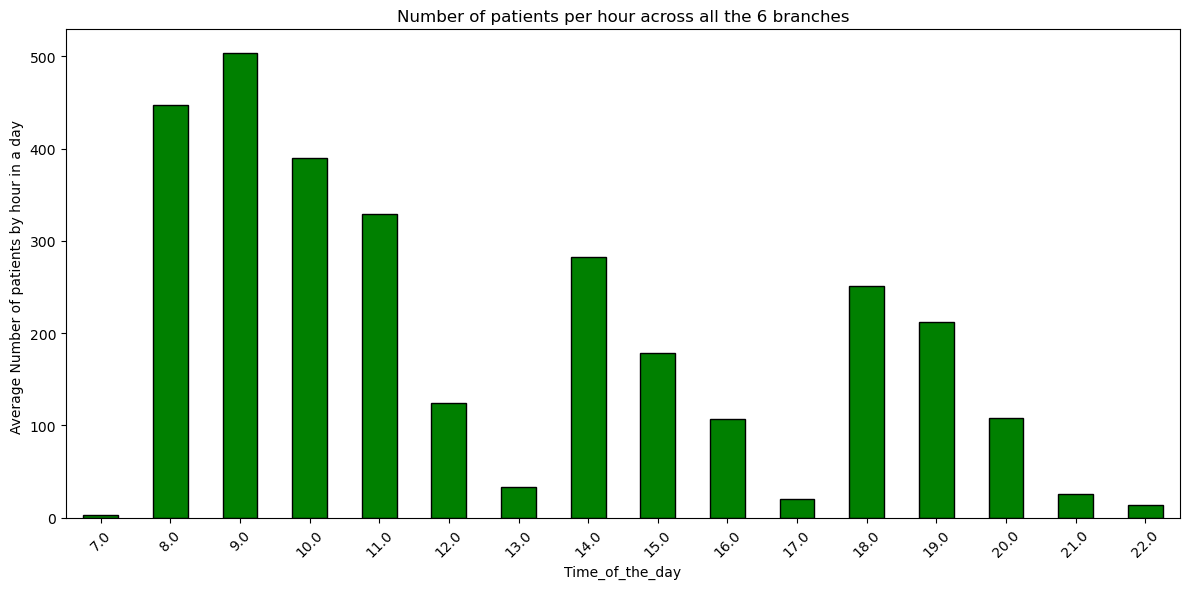

In [33]:
# Average patients by day
plt.figure(figsize=(12, 6))
average_patients_by_hour.plot(kind='bar', color='green', edgecolor='black')
plt.title('Number of patients per hour across all the 6 branches')
plt.ylabel('Average Number of patients by hour in a day ')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 1.5.2 EDA Question 2: How does the trend in patient waiting time look like over time?

<Axes: xlabel='Day_of_Week'>

<Figure size 1500x1000 with 0 Axes>

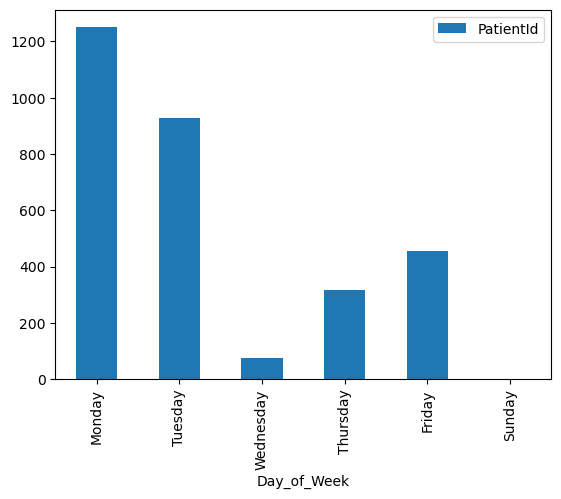

In [34]:
plt.figure(figsize=(15, 10))
df_grouped = data.groupby('Day_of_Week')['PatientId'].count().reset_index()
# Use Dan's trick to order days names in the table created by groupby
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mapping = {Day_of_Week: i for i, Day_of_Week in enumerate(weekdays)}
key = df_grouped['Day_of_Week'].map(mapping)    
df_grouped = df_grouped.iloc[key.argsort()]
# Draw the bar chart
df_grouped.plot(kind='bar', x='Day_of_Week')

### EDA Question 4: What is the age distribtion of patients included under study

In [35]:
# Display the minimum and maxiumum age 
print("Minimum age:", data['Age'].min())
print("Maximum age:", data['Age'].max())

Minimum age: 18
Maximum age: 85


### EDA Question 5: Which health conditions were observed among most patients

(-0.5, 1599.5, 799.5, -0.5)

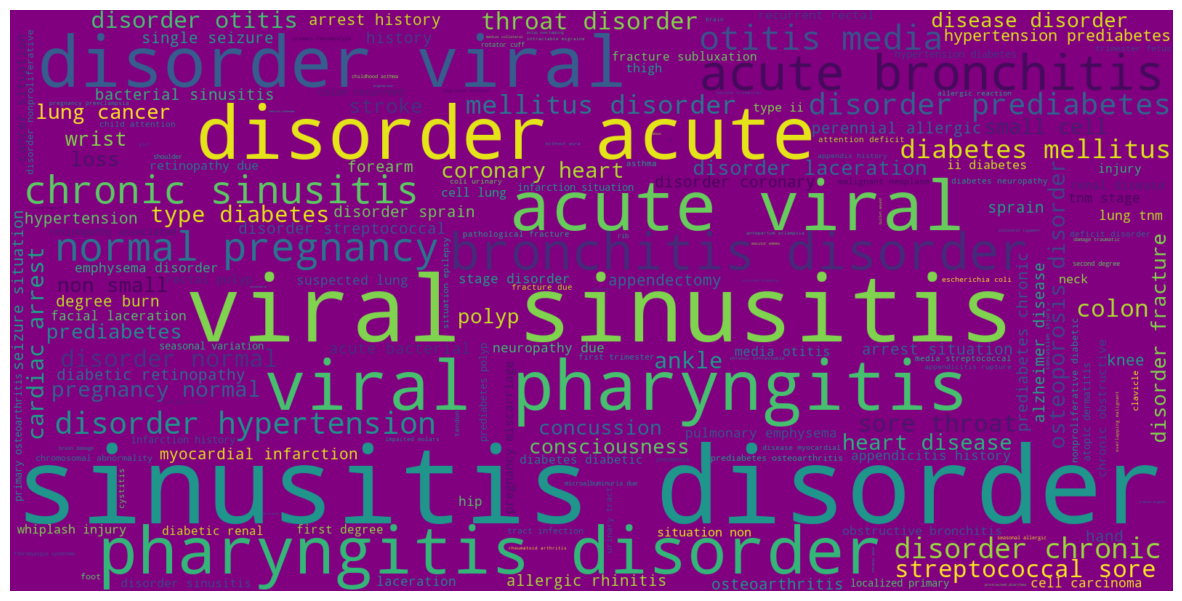

In [42]:
word_string = " ".join(data['Symptoms_Conditions'].str.lower())

plt.figure(figsize=(15,15))
wc = WordCloud(background_color="purple", stopwords = STOPWORDS, max_words=2000, max_font_size= 300,  width=1600, height=800)
wc.generate(word_string)

plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), interpolation="bilinear")
plt.axis('off')

## 4 Spliting Data into training and testing sets

#### 4.1 Inspecting data again

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3029 entries, 2024-05-29 to 2024-05-27
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Region                    3029 non-null   int64         
 1   Branch                    3029 non-null   int64         
 2   PatientId                 3029 non-null   object        
 3   Sex                       3029 non-null   int64         
 4   Age                       3029 non-null   int64         
 5   Had_appointment           3029 non-null   int64         
 6   p_ArrivalTime             3029 non-null   datetime64[ns]
 7   p_ConsultationTime_0      3029 non-null   datetime64[ns]
 8   p_ConsultationTime_c      3029 non-null   datetime64[ns]
 9   is_on_Medical_aid         3029 non-null   int64         
 10  Repeat_visit_past_3Month  3029 non-null   int64         
 11  Queue_length              3029 non-null   int64         
 12  Sy

We now have 19 variable and it's now time to remove the redundant variable

#### 4.2 Dropping redundant variables and object variables

In [44]:
data.drop("PatientId", axis =  1, inplace = True)

In [45]:
data.drop("p_ArrivalDate_" , axis =  1, inplace = True)

In [46]:
data.drop("Day_of_Week", axis =  1, inplace = True)

In [47]:
data.drop("Symptoms_Conditions", axis =  1, inplace = True)

In [48]:
data.drop("p_ArrivalTime", axis =  1, inplace = True)

In [49]:
data.drop("p_ConsultationTime_0", axis =  1, inplace = True)

In [50]:
data.drop("p_ConsultationTime_c", axis =  1, inplace = True)

In [51]:
data.drop("p_waiting_time (Mins)", axis =  1, inplace = True)

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3029 entries, 2024-05-29 to 2024-05-27
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Region                    3029 non-null   int64  
 1   Branch                    3029 non-null   int64  
 2   Sex                       3029 non-null   int64  
 3   Age                       3029 non-null   int64  
 4   Had_appointment           3029 non-null   int64  
 5   is_on_Medical_aid         3029 non-null   int64  
 6   Repeat_visit_past_3Month  3029 non-null   int64  
 7   Queue_length              3029 non-null   int64  
 8   Referral                  3029 non-null   int64  
 9   Time_of_the_day           3029 non-null   float64
 10  Weekdays                  3029 non-null   int64  
 11  Delay_Yes_No              3029 non-null   int32  
dtypes: float64(1), int32(1), int64(10)
memory usage: 295.8 KB


In [53]:
# Split the data to maintain the distribution of the target variable
_, simulated_set = train_test_split(
    data, 
    test_size=0.2, 
    stratify=data['Delay_Yes_No'],  # Stratify based on the target variable
    random_state=42
)

# Set the targets to NaN
simulated_set['Delay_Yes_No'] = np.nan

# Save the simulated set to a CSV file
simulated_set.to_csv('./data/input/simulated_set.csv', index=False)

print("Stratified simulated set saved to './data/input/simulated_set.csv'")

Stratified simulated set saved to './data/input/simulated_set.csv'


## Statistical Testing

In this section, we will apply Statistical Testing to help understand the impact of the features on the target. For example:

Perform Chi-square test between Gender and the target variable (Delayed Service) to see if Gender impacts the target.
Perform Chi-square test between  is_on_Medical_aid  and the target variable (Delayed) to see if being on medical aid has impact the target.
Is the patient's type of disease has an interplay with longer waiting time? Check its significance with the target variable using relevant testing techniques.

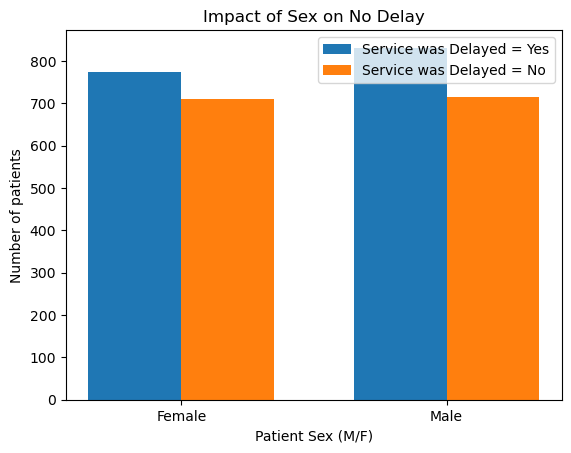

In [54]:
# Create the contingency table for Sex and Delay
contingency_table_gender = pd.crosstab(data['Sex'], data['Delay_Yes_No'])

# Plotting the bar chart
fig, ax = plt.subplots()

# Set positions and width for the bars[p;,,lo
pos = list(range(len(contingency_table_gender[1])))
bar_width = 0.35

# Plot bars for '1' and '0' in 'NO_SHOW'
plt.bar(pos, contingency_table_gender[1], bar_width, label='Service was Delayed = Yes')
plt.bar([p + bar_width for p in pos], contingency_table_gender[0], bar_width, label='Service was Delayed = No')

# Set axis labels and title
ax.set_xticks([p + 0.5 * bar_width for p in pos])
ax.set_xticklabels(['Female', 'Male'])
plt.xlabel('Patient Sex (M/F)')
plt.ylabel('Number of patients')
plt.title('Impact of Sex on No Delay')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [55]:
# Create a contingency table
# This table will show the frequency distribution of no-shows across different genders
contingency_table = pd.crosstab(data['Sex'], data['Delay_Yes_No'])

# Perform the Chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Print the results of the Chi-square test
print("Results")
print(f"Chi-square value: {chi2}") # The Chi-square statistic
print(f"P-value: {p_value}") # The p-value of the test
print(f"Degrees of Freedom: {dof}") # Degrees of freedom


# Interpret the results based on the p-value and a significance level of 0.05
alpha = 0.05  # Significance level
print("\nConclusion")
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant relationship between Gender and Delayed_Service.")
else:
    print("Fail to reject the null hypothesis. There is no significant relationship between Gender and Delayed_Service.")

Results
Chi-square value: 0.678264164375924
P-value: 0.4101850944133216
Degrees of Freedom: 1

Conclusion
Fail to reject the null hypothesis. There is no significant relationship between Gender and Delayed_Service.


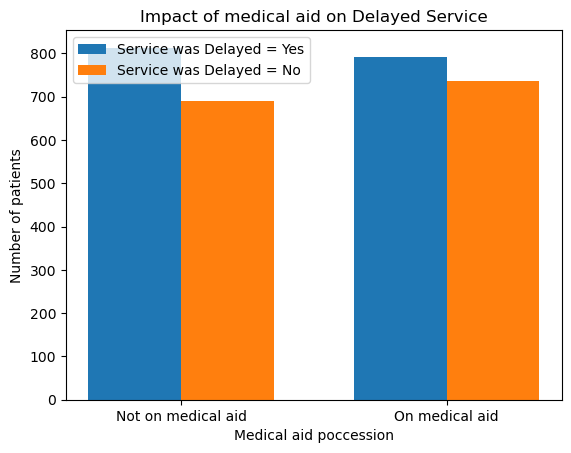

In [56]:
# Create the contingency table for contingency_table_medicalAid and Delayed_Service
contingency_table_medicalAid = pd.crosstab(data['is_on_Medical_aid'], data['Delay_Yes_No'])

# Plotting the bar chart
fig, ax = plt.subplots()

# Set positions and width for the bars
pos = list(range(len(contingency_table_medicalAid[1])))
bar_width = 0.35

# Plot bars for '1' and '0' in 'NO_SHOW'
plt.bar(pos, contingency_table_medicalAid[1], bar_width, label='Service was Delayed = Yes')
plt.bar([p + bar_width for p in pos], contingency_table_medicalAid[0], bar_width, label='Service was Delayed = No')

# Set axis labels and title
ax.set_xticks([p + 0.5 * bar_width for p in pos])
ax.set_xticklabels(['Not on medical aid', 'On medical aid'])
plt.xlabel('Medical aid poccession')
plt.ylabel('Number of patients')
plt.title('Impact of medical aid on Delayed Service')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [57]:
# Create a contingency table
# This table will show the frequency distribution of delayed service across patients with and without medical aid
contingency_table_medicalAid = pd.crosstab(data['is_on_Medical_aid'], data['Delay_Yes_No'])

# Perform the Chi-square test
chi2_medicalAid, p_value_medicalAid, dof_medicalAid, expected_medicalAid = chi2_contingency(contingency_table_medicalAid)

# Print the results of the Chi-square test
print("Results")
print(f"Chi-square value: {chi2_medicalAid}")  # The Chi-square statistic
print(f"P-value: {p_value_medicalAid}")  # The p-value of the test
print(f"Degrees of Freedom: {dof_medicalAid}")  # Degrees of freedom

# Interpret the results based on the p-value and a significance level of 0.05
alpha = 0.05  # Significance level
print("\nConclusion")
if p_value_medicalAid < alpha:
    print("Reject the null hypothesis. There is a significant relationship between medical aid poccession and Service delay.")
else:
    print("Fail to reject the null hypothesis. There is no significant relationship between  medical aid poccession and Service delay.")

Results
Chi-square value: 1.465032819551842
P-value: 0.2261310410828151
Degrees of Freedom: 1

Conclusion
Fail to reject the null hypothesis. There is no significant relationship between  medical aid poccession and Service delay.


## Stratified Hold-out Split

In this section, we will be performing a stratified hold-out split on the dataset. The goal is to divide the data into training and testing sets while maintaining the distribution of the target variable, Delayed, in both subsets. This ensures that the model will be trained and evaluated on data that is representative of the overall distribution of the target variable.

We will also visualize the distribution of Delayed_service before and after the split to confirm that the stratification worked as expected.

In [58]:
data['Delay_Yes_No'].value_counts()

Delay_Yes_No
1    1605
0    1424
Name: count, dtype: int64

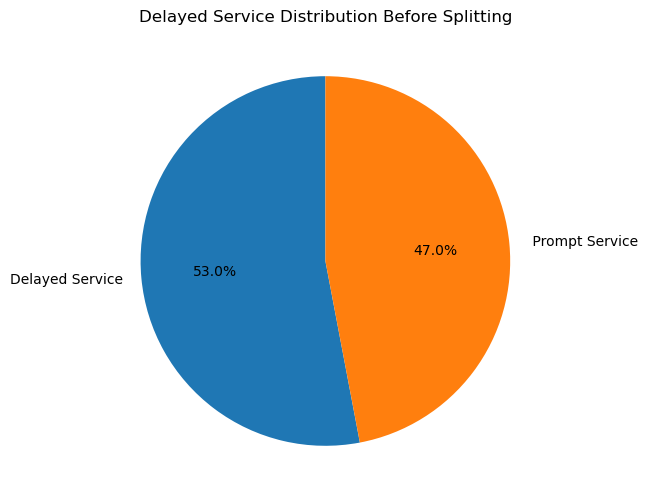

In [59]:
# Visualize the distribution of 'Delayed Service' before splitting using a pie chart
plt.figure(figsize=(6, 6))
data['Delay_Yes_No'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, labels=['Delayed Service', ' Prompt Service'])
plt.title('Delayed Service Distribution Before Splitting')
plt.ylabel('')  # Hide the y-axis label for clarity
plt.show()

We can now perform the 80-20 stratified split and verify the target class distribution stays the same before and after splitting.

In [60]:
# Perform the 80%-20% stratified split
train_data, test_data = train_test_split(data, test_size=0.20, stratify=data['Delay_Yes_No'], random_state=42)

In [61]:
# Calculate the value counts for the 'Delayed Service' column in the training set
train_value_counts = train_data['Delay_Yes_No'].value_counts(normalize=True) * 100

# Calculate the value counts for the 'Delayed Service' column in the test set
test_value_counts = test_data['Delay_Yes_No'].value_counts(normalize=True) * 100

# Round the value counts to 1 decimal place
train_value_counts = train_value_counts.round(1)
test_value_counts = test_value_counts.round(1)

# Display the rounded value counts
print("Training set 'Delayed Service' value counts (in %):")
display(train_value_counts)

print("\nTest set 'Delayed Service' value counts (in %):")
display(test_value_counts)

Training set 'Delayed Service' value counts (in %):


Delay_Yes_No
1    53.0
0    47.0
Name: proportion, dtype: float64


Test set 'Delayed Service' value counts (in %):


Delay_Yes_No
1    53.0
0    47.0
Name: proportion, dtype: float64

In [62]:
# Check the shape of the training set
print(f"Shape of training set: {train_data.shape}")

# Check the shape of the testing set
print(f"Shape of testing set: {test_data.shape}")

Shape of training set: (2423, 12)
Shape of testing set: (606, 12)


## Feature Engineering and Additional Data Preprocessing

### Feature Selection

In this section, we will perform feature selection to identify the most important features for our model. Feature selection is crucial for making the model simpler, faster, and more interpretable.

To further refine our feature selection, we will use machine learning models to compute the feature importance. We will use Logistic Regression and Decision Trees for this purpose. This step will help us understand which features are most influential in predicting the target variable.

In [63]:
# Reorder columns to make 'Delayed Service' the last column in train_data
cols_train = list(train_data.columns)
cols_train.remove('Delay_Yes_No')
cols_train.append('Delay_Yes_No')
train_data = train_data[cols_train]

# Reorder columns to make 'Delayed Service' the last column in test_data
cols_test = list(test_data.columns)
cols_test.remove('Delay_Yes_No')
cols_test.append('Delay_Yes_No')
test_data = test_data[cols_test]

In [64]:
corr_matrix = train_data.corr()

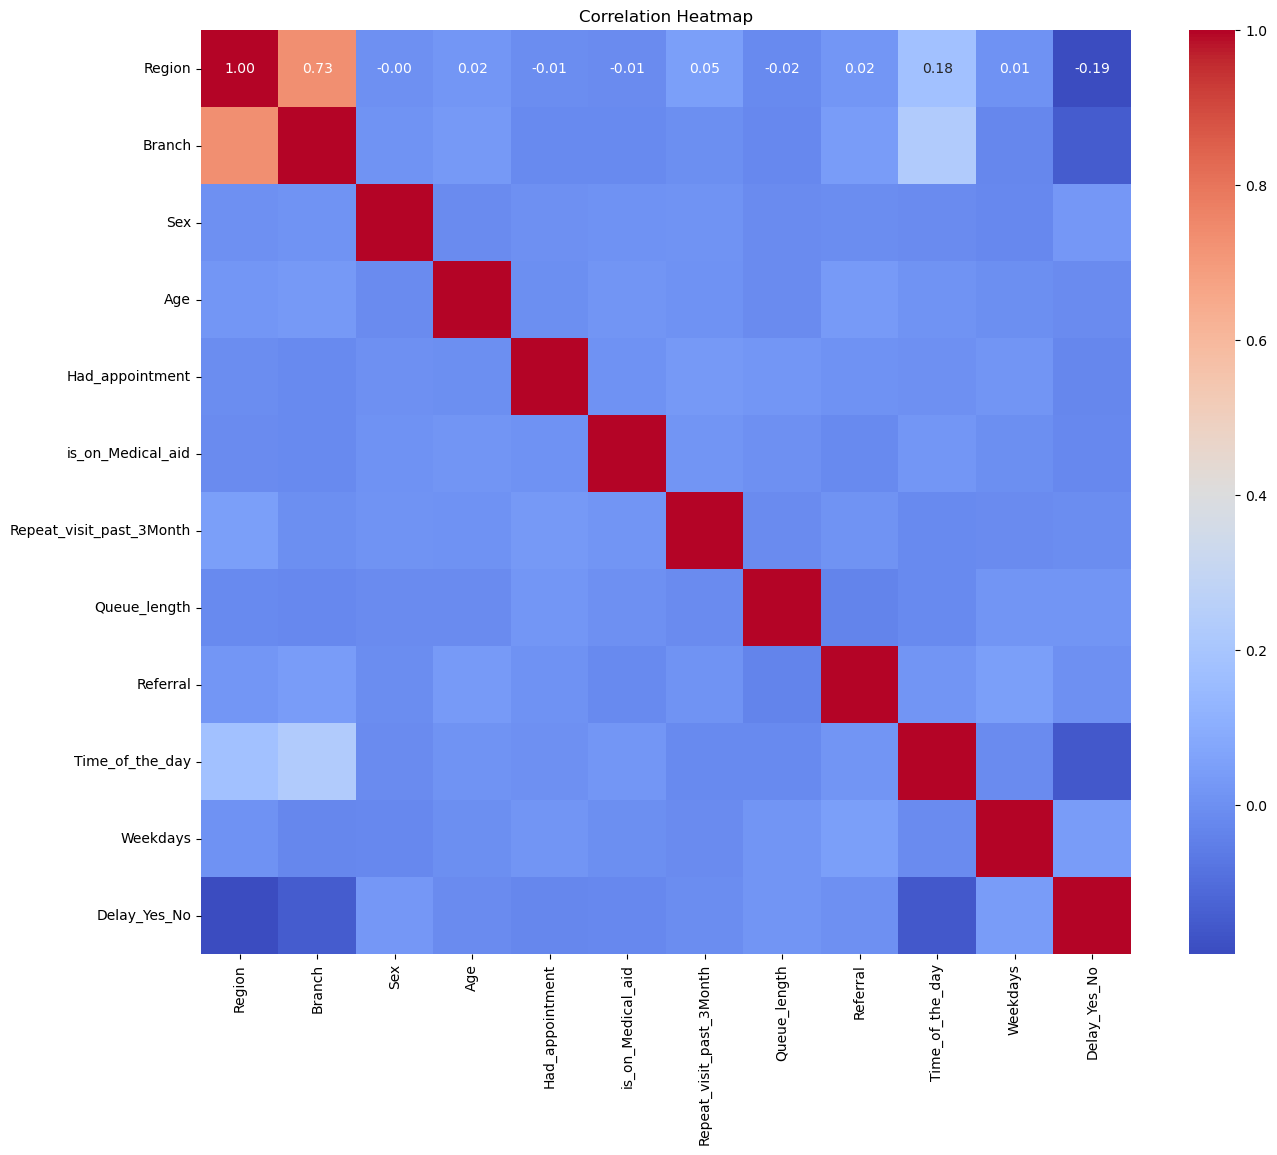

In [65]:
# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

#### Logistic Regression Coefficient

We will look at the coefficients of the logistic regression model to understand the impact of each feature on the target variable.

We will focus on features that have at least 1% importance in either of the models.

#### Unsampling

In [66]:
# Separate majority and minority classes in the original training set
train_majority = train_data[train_data.Delay_Yes_No  == 1]
train_minority = train_data[train_data.Delay_Yes_No  == 0]

# Upsample minority class
train_minority_upsampled = resample(train_minority, 
                                    replace=True,     # sample with replacement
                                    n_samples=len(train_majority),    # to match majority class
                                    random_state=123) # reproducible results

# Combine majority class with upsampled minority class
train_upsampled = pd.concat([train_majority, train_minority_upsampled]).reset_index(drop=True)

In [67]:
# Downsample majority class
train_majority_downsampled = resample(train_majority, 
                                      replace=True,    # sample without replacement
                                      n_samples=len(train_minority),  # to match minority class
                                      random_state=123) # reproducible results

# Combine minority class with downsampled majority class
train_downsampled = pd.concat([train_majority_downsampled, train_minority]).reset_index(drop=True)

In [68]:
# Separate features and target variable from original training data
X_train = train_data.drop('Delay_Yes_No', axis=1)
y_train = train_data['Delay_Yes_No']


In [69]:
# Initialize the scaler
scaler = StandardScaler()

# List of feature columns to scale
feature_cols = train_data.columns.difference(['Delay_Yes_No'])

In [70]:
# Create copies of the original data
train_data_scaled = train_data.copy()
test_data_scaled = test_data.copy()

# Apply scaling to the feature columns in the training and test sets
train_data_scaled[feature_cols] = scaler.fit_transform(train_data[feature_cols])
test_data_scaled[feature_cols] = scaler.transform(test_data[feature_cols])

In [71]:
# Create copies of the resampled data
train_upsampled_scaled = train_upsampled.copy()
train_downsampled_scaled = train_downsampled.copy()


# Apply scaling to the feature columns in the resampled datasets
train_upsampled_scaled[feature_cols] = scaler.transform(train_upsampled[feature_cols])
train_downsampled_scaled[feature_cols] = scaler.transform(train_downsampled[feature_cols])


Check if we have implemented Standard Scaling correctly.

In [72]:
#Define a function to check if the mean is close to 0 and the standard deviation is close to 1
def check_scaling(df, cols_to_scale):
    return all(np.isclose(df[col].mean(), 0, atol=2e-1) and np.isclose(df[col].std(), 1, atol=2e-1) for col in cols_to_scale)

# List of feature columns to scale
feature_cols = train_data.columns.difference(['Delay_Yes_No'])

# Perform the sanity check on all datasets
print("Sanity check for original scaled training set:", check_scaling(train_data_scaled, feature_cols))
print("Sanity check for scaled test set:", check_scaling(test_data_scaled, feature_cols))
print("Sanity check for scaled upsampled set:", check_scaling(train_upsampled_scaled, feature_cols))
print("Sanity check for scaled downsampled set:", check_scaling(train_downsampled_scaled, feature_cols))

Sanity check for original scaled training set: True
Sanity check for scaled test set: True
Sanity check for scaled upsampled set: True
Sanity check for scaled downsampled set: True


##### Logistic Regression

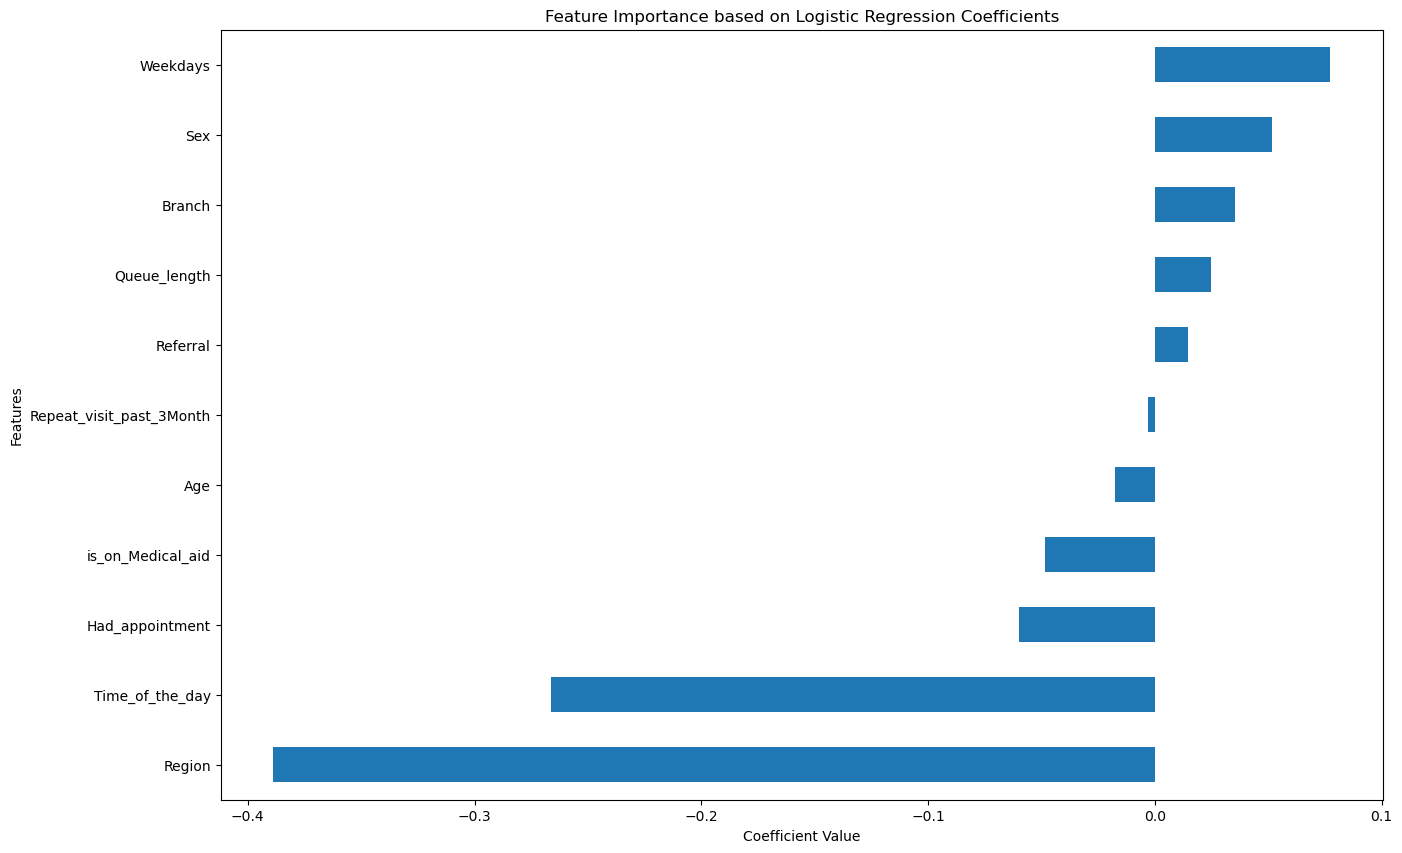

Important features based on Logistic Regression:
                   Coefficient
Region               -0.388730
Branch                0.035232
Sex                   0.051907
Age                  -0.017635
Had_appointment      -0.059684
is_on_Medical_aid    -0.048192
Queue_length          0.024883
Referral              0.014866
Time_of_the_day      -0.266394
Weekdays              0.077367
Number of important features in Logistic Regression: 10


In [73]:
# Initialize the Logistic Regression model
logistic_model = LogisticRegression(class_weight='balanced', random_state=42)

# Fit the model on the scaled training data
logistic_model.fit(train_data_scaled.drop('Delay_Yes_No', axis=1), train_data_scaled['Delay_Yes_No'])

# Get the coefficients from the trained model
logistic_coef = pd.DataFrame(logistic_model.coef_.reshape(-1, 1), index=train_data_scaled.drop('Delay_Yes_No', axis=1).columns, columns=['Coefficient'])

# Plotting the feature importance
plt.figure(figsize=(15, 10))
logistic_coef['Coefficient'].sort_values().plot(kind='barh')
plt.title('Feature Importance based on Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()

# Filter features with at least 1% importance (0.01)
important_features_logistic = logistic_coef[abs(logistic_coef['Coefficient']) >= 0.01]

# Display the important features and their count
print("Important features based on Logistic Regression:")
print(important_features_logistic)
print(f"Number of important features in Logistic Regression: {len(important_features_logistic)}")

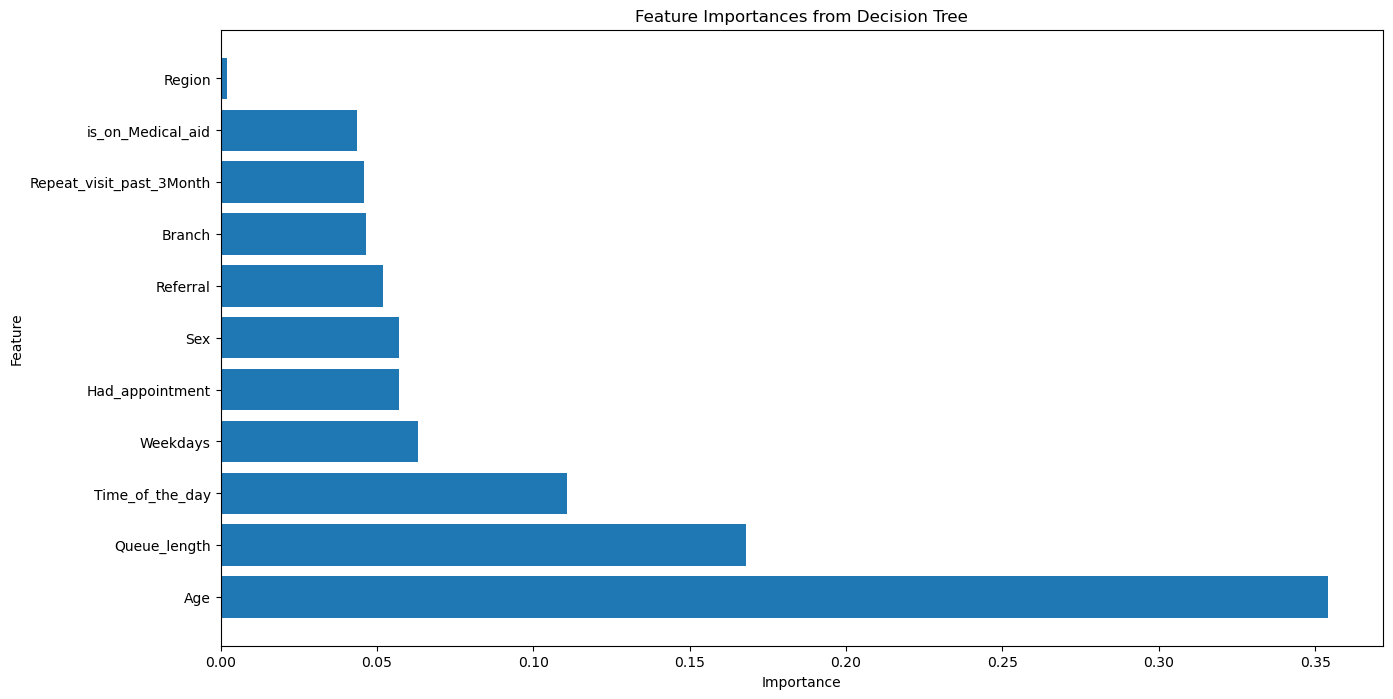

Important features based on Decision Tree:
                     Feature  Importance
3                        Age    0.354011
7               Queue_length    0.167947
9            Time_of_the_day    0.110653
10                  Weekdays    0.063018
4            Had_appointment    0.057194
2                        Sex    0.057126
8                   Referral    0.051845
1                     Branch    0.046605
6   Repeat_visit_past_3Month    0.045999
5          is_on_Medical_aid    0.043596
Number of important features in Decision Tree: 10


In [74]:
# Initialize the Decision Tree model
decision_tree_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Fit the model on the training data
decision_tree_model.fit(train_data.drop('Delay_Yes_No', axis=1), train_data['Delay_Yes_No'])

# Get the feature importances
feature_importances = decision_tree_model.feature_importances_

# Create a DataFrame for the feature importances
feature_importances_df = pd.DataFrame({'Feature': train_data.drop('Delay_Yes_No', axis=1).columns, 'Importance': feature_importances})

# Sort the DataFrame by the importances
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

# Filter features with at least 1% importance
important_features_tree = feature_importances_df[feature_importances_df['Importance'] >= 0.01]

# Plotting all feature importances
plt.figure(figsize=(15, 8))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Decision Tree')
plt.show()

print("Important features based on Decision Tree:")
print(important_features_tree)
print(f"Number of important features in Decision Tree: {len(important_features_tree)}")

In [75]:
# Convert the important features to lists
important_features_logistic_list = important_features_logistic.index.values.tolist()
important_features_tree_list = important_features_tree['Feature'].values.tolist()

# Find the intersection of both lists
combined_important_features_union = list(set(important_features_logistic_list) | 
                                                set(important_features_tree_list))

print("Combined important features (Union):")
display(combined_important_features_union)
print(f"Total number of combined important features (Intersection): {len(combined_important_features_union)}")

Combined important features (Union):


['Had_appointment',
 'Age',
 'Queue_length',
 'Referral',
 'Time_of_the_day',
 'is_on_Medical_aid',
 'Branch',
 'Sex',
 'Repeat_visit_past_3Month',
 'Weekdays',
 'Region']

Total number of combined important features (Intersection): 11


In [76]:
# Add 'NO_SHOW' to the list of important features
combined_important_features_union.append('Delay_Yes_No')

print(f"Total number of combined important features (Union) with target: {len(combined_important_features_union)}")

Total number of combined important features (Union) with target: 12


In [77]:
# Filter the original training and test sets
train_data_filtered = train_data[combined_important_features_union]
test_data_filtered = test_data[combined_important_features_union]

# Filter the scaled training and test sets
train_data_scaled_filtered = train_data_scaled[combined_important_features_union]
test_data_scaled_filtered = test_data_scaled[combined_important_features_union]

# Filter the upsampled, downsampled, and SMOTE sets
train_upsampled_filtered = train_upsampled[combined_important_features_union]
train_downsampled_filtered = train_downsampled[combined_important_features_union]


# Filter the scaled and upsampled, downsampled, and SMOTE sets
train_upsampled_scaled_filtered = train_upsampled_scaled[combined_important_features_union]
train_downsampled_scaled_filtered = train_downsampled_scaled[combined_important_features_union]


## Modeling

### Dataset Preperation

We will prepare the datasets that will be used for training and testing the models.

In [78]:
# Original training sets
X_train = train_data_filtered.drop('Delay_Yes_No', axis=1)
y_train = train_data_filtered['Delay_Yes_No']

# Original test sets
X_test = test_data_filtered.drop('Delay_Yes_No', axis=1)
y_test = test_data_filtered['Delay_Yes_No']

# Scaled training and test sets
X_train_scaled = train_data_scaled_filtered.drop('Delay_Yes_No', axis=1)
X_test_scaled = test_data_scaled_filtered.drop('Delay_Yes_No', axis=1)

In [79]:
# Upsampled set
X_train_upsampled = train_upsampled_filtered.drop('Delay_Yes_No', axis=1)
y_train_upsampled = train_upsampled_filtered['Delay_Yes_No']

# Downsampled set
X_train_downsampled = train_downsampled_filtered.drop('Delay_Yes_No', axis=1)
y_train_downsampled = train_downsampled_filtered['Delay_Yes_No']


# Scaled and upsampled set
X_train_upsampled_scaled = train_upsampled_scaled_filtered.drop('Delay_Yes_No', axis=1)

# Scaled and downsampled set
X_train_downsampled_scaled = train_downsampled_scaled_filtered.drop('Delay_Yes_No', axis=1)


### Model Selection


We will train multiple machine learning models (Logistic Regression, Decision Tree, Random Forest, and XGBoost) with Stratified K-Fold cross-validation on the original dataset to identify the one that performs best based on the ROC AUC.


In [80]:
# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize models
logistic_model = LogisticRegression(class_weight='balanced', random_state=42)
decision_tree_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
random_forest_model = RandomForestClassifier(class_weight='balanced', random_state=42)
xgb_model = XGBClassifier(scale_pos_weight=(0.798 / 0.202), random_state=42)

# Perform cross-validation for each model
models = {'Logistic Regression': logistic_model, 
          'Decision Tree': decision_tree_model, 
          'Random Forest': random_forest_model, 
          'XGBoost': xgb_model}

for name, model in models.items():
    if name == 'Logistic Regression':
        score = (cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='roc_auc', n_jobs=-1).mean())                        
    else:
        score = (cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1).mean())                              
    
    print(f"Results for {name}:")
    print(f"ROC AUC: {score}")
    print("------")

Results for Logistic Regression:
ROC AUC: 0.6218110862722019
------
Results for Decision Tree:
ROC AUC: 0.5334519937987979
------
Results for Random Forest:
ROC AUC: 0.596958944324262
------
Results for XGBoost:
ROC AUC: 0.5656884547733221
------


XGBoost is the best performing model with highest ROC AUC trained on the original dataset.

### Dataset selection

We will fit the best model (XGBoost) on priginal data set as well as different resampled data sets, and evaluate on the test set. This is to see how the model performs on different versions of the dataset. It will help us identify which resampling technique (if any) improves the model's performance on the test set.

In [81]:
# Initialize the XGBoost model for original dataset
xgb_model_original = XGBClassifier(scale_pos_weight=(0.798 / 0.202), random_state=42)

# Initialize the XGBoost model for resampled datasets
xgb_model_resampled = XGBClassifier(random_state= 42 )

# Datasets
datasets = {
    'Original': (X_train, y_train),
    'Upsampled': (X_train_upsampled, y_train_upsampled),
    'Downsampled': (X_train_downsampled, y_train_downsampled),
    
}

# To store results
results = {}

# Loop through each dataset
for name, (X, y) in datasets.items():
    if name == 'Original':
        model = xgb_model_original
    else:
        model = xgb_model_resampled
    
    # Fit the model
    model.fit(X, y)

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class
    
    # Evaluate the model
    roc_auc = roc_auc_score(y_test, y_pred_prob)  # Use probabilities for ROC AUC
    f1 = f1_score(y_test, y_pred)
    
    results[name] = {'ROC AUC': roc_auc, 'F1 Score': f1}

# Display the results
for name, metrics in results.items():
    print(f"Results for {name}:")
    print(f"ROC AUC: {metrics['ROC AUC']}")
    print(f"F1 Score: {metrics['F1 Score']}")
    print("------")

Results for Original:
ROC AUC: 0.5891785538612887
F1 Score: 0.6525759577278731
------
Results for Upsampled:
ROC AUC: 0.5726293927966333
F1 Score: 0.6216596343178622
------
Results for Downsampled:
ROC AUC: 0.6044269552385637
F1 Score: 0.5238938053097345
------


Based on the results, the XGBoost model trained on the original dataset and evaluated on test set performs slightly better in terms of both ROC AUC and F1 Score compared to the models trained on the resampled datasets.


### Save reduced input features


We will save the new features without target into pickle. This allows us to easily reuse them in future runs of our analysis or in deployment scenarios, ensuring consistency and reproducibility.

In [82]:
# Retrain the model on the Upsampled dataset
xgb_model_original = XGBClassifier(scale_pos_weight=(0.798 / 0.202), random_state=42)
xgb_model_original.fit(X_train, y_train)

# Extract feature importances from the trained XGBoost model
feature_importances = xgb_model_original.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
# Sort the DataFrame by the importances
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Filter features with at least 1% importance
important_features_revisited = feature_importance_df[feature_importance_df['Importance'] >= 0.01]

# Filter the training and test sets to include only the new set of important features
new_important_features = important_features_revisited['Feature'].tolist()
X_train_filtered = X_train[new_important_features]
X_test_filtered = X_test[new_important_features]

In [83]:
# Save the new important features to a pickle file
with open('./data/features/X_train_important_features.pkl', 'wb') as f:
    pickle.dump(new_important_features, f)

## Hyperparameter Tuning

We will fine-tune the hyperparameters of the selected model using Hyperopt. The objective is to maximize the ROC AUC score. Hyperopt employs Bayesian optimization to find the best hyperparameters more efficiently than grid search or random search.

Here's a general outline of the steps we will follow:

* Define the Objective Function: This function will take in hyperparameters, train the Gradient Boosting model, and return the metric we want to optimize (in this case, ROC AUC).
* Define the Hyperparameter Space: Specify the range of values for each hyperparameter we want to tune.
 - n_estimators: The number of boosting rounds or trees to build. It's important to tune it properly as a very large number would make the model overfit. Range: [50, 1000].
- max_depth: The maximum depth of the individual estimators. The depth of the tree can be used to control over-fitting. Range: [3, 14].
- learning_rate: Step size shrinkage used to prevent overfitting. Range is [0.01, 0.2].
- gamma: Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be. Range: [0, 0.5].
- colsample_bytree: The fraction of features to choose for each boosting round. Used for subsampling of columns. Range: [0.3, 1].
subsample: The fraction of samples to be used for each boosting round. Range: [0.6, 1].
- min_child_weight: Minimum sum of instance weight (hessian) needed in a child. Used to control over-fitting. Range: [1, 10].
- Run Optimization: Use Hyperopt to run the optimization process.

In [84]:
# Load the important features from the pickle file
with open('./data/features/X_train_important_features.pkl', 'rb') as f:
    important_features = pickle.load(f)

# Filter the original X_train and X_test dataset to include only the important features
X_train_filtered = X_train[important_features]
X_test_filtered = X_test[important_features]

In [85]:
best_score = 0  # Initialize the best score
iteration = 0  # Initialize the iteration counter

# Define the objective function
def objective(params):
    global best_score  # Declare best_score as global to update it
    global iteration  # Declare iteration as global to update it
    iteration += 1  # Increment the iteration counter
    
    clf = XGBClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        gamma=params['gamma'],
        colsample_bytree=params['colsample_bytree'],
        subsample=params['subsample'],
        min_child_weight=int(params['min_child_weight']),
        scale_pos_weight=(0.798 / 0.202),
        random_state=42
    )
    
    # Stratified K-Fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(clf, X_train_filtered, y_train, cv=skf, scoring='roc_auc', n_jobs=-1).mean()
    
    if score > best_score:
        best_score = score
        print(f"New best score at iteration {iteration}: {best_score}")
        display("Best parameters so far:", params)
    
    return {'loss': -score, 'status': STATUS_OK}
    # Define the parameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 1000, 1),
    'max_depth': hp.quniform('max_depth', 3, 14, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1),
    'subsample': hp.uniform('subsample', 0.6, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1)
}

# Initialize a trials object
trials = Trials()

# Run the hyperparameter optimization
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

New best score at iteration 1: 0.5999636954910095                                                                      
  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

'Best parameters so far:'

{'colsample_bytree': 0.7867537751513085,
 'gamma': 0.4331542907637572,
 'learning_rate': 0.020080501661752924,
 'max_depth': 14.0,
 'min_child_weight': 3.0,
 'n_estimators': 144.0,
 'subsample': 0.9254541727970635}

New best score at iteration 17: 0.6122087949120845                                                                     
 16%|███████▎                                      | 16/100 [00:10<01:15,  1.11trial/s, best loss: -0.5999636954910095]

'Best parameters so far:'

{'colsample_bytree': 0.3982262001021794,
 'gamma': 0.3970623386702063,
 'learning_rate': 0.08769235906600532,
 'max_depth': 6.0,
 'min_child_weight': 6.0,
 'n_estimators': 56.0,
 'subsample': 0.6139273478916902}

New best score at iteration 21: 0.6233547598585725                                                                     
 20%|█████████▏                                    | 20/100 [00:13<01:02,  1.29trial/s, best loss: -0.6122087949120845]

'Best parameters so far:'

{'colsample_bytree': 0.998851033534705,
 'gamma': 0.4802825441617918,
 'learning_rate': 0.01081764800871194,
 'max_depth': 5.0,
 'min_child_weight': 7.0,
 'n_estimators': 53.0,
 'subsample': 0.6212757617639146}

New best score at iteration 25: 0.6256278023828437                                                                     
 24%|███████████                                   | 24/100 [00:14<00:36,  2.10trial/s, best loss: -0.6233547598585725]

'Best parameters so far:'

{'colsample_bytree': 0.3970144971146437,
 'gamma': 0.2659577024489855,
 'learning_rate': 0.01337341236039312,
 'max_depth': 5.0,
 'min_child_weight': 6.0,
 'n_estimators': 116.0,
 'subsample': 0.6418216698073204}

New best score at iteration 33: 0.627357021913266                                                                      
 32%|██████████████▋                               | 32/100 [00:18<00:35,  1.91trial/s, best loss: -0.6256278023828437]

'Best parameters so far:'

{'colsample_bytree': 0.6752469896389754,
 'gamma': 0.3308065093011856,
 'learning_rate': 0.01147406358155802,
 'max_depth': 6.0,
 'min_child_weight': 10.0,
 'n_estimators': 101.0,
 'subsample': 0.6339118222185114}

New best score at iteration 43: 0.6290058130490256                                                                     
 42%|███████████████████▋                           | 42/100 [00:25<00:52,  1.11trial/s, best loss: -0.627357021913266]

'Best parameters so far:'

{'colsample_bytree': 0.7911543004657644,
 'gamma': 0.26287837558609645,
 'learning_rate': 0.017586661522480992,
 'max_depth': 3.0,
 'min_child_weight': 1.0,
 'n_estimators': 157.0,
 'subsample': 0.6773854330797197}

New best score at iteration 67: 0.6324679673857059                                                                     
 66%|██████████████████████████████▎               | 66/100 [00:42<00:23,  1.42trial/s, best loss: -0.6290058130490256]

'Best parameters so far:'

{'colsample_bytree': 0.4932499717441343,
 'gamma': 0.2561123217764056,
 'learning_rate': 0.015922884782500046,
 'max_depth': 3.0,
 'min_child_weight': 3.0,
 'n_estimators': 81.0,
 'subsample': 0.6866518085929362}

100%|█████████████████████████████████████████████| 100/100 [01:01<00:00,  1.63trial/s, best loss: -0.6324679673857059]


The best loss (which is actually the negative of the ROC AUC score, because Hyperopt minimizes the loss) is approximately 0.7134189126644291. This suggests that hyperparameter tuning has led to a slight improvement in the model's performance as compared to the mean ROC AUC score we obtained before tuning of 0.5747453889841114 

## Save best hyperparameters

In [86]:
# Best parameters obtained from hyperparameter tuning
best_params = {
    'n_estimators': int(344),  # Convert float to int
    'max_depth': int(11),  # Convert float to int
    'learning_rate': 0.01024371856856813,
    'gamma': 0.4565024075152735,
    'colsample_bytree': 0.5547103400612381,
    'subsample': 0.8528421424055362,
    'min_child_weight': int(5),  # Convert float to int
    'scale_pos_weight': 0.798 / 0.202,
    'random_state': 42
}

# Save the best hyperparameters to a pickle file
with open('./data/hyperparameters/XGBoost_hyperparameters.pkl', 'wb') as f:
    pickle.dump(best_params, f)
    
print("Best hyperparameters saved to './data/hyperparameters/XGBoost_hyperparameters.pkl'")

Best hyperparameters saved to './data/hyperparameters/XGBoost_hyperparameters.pkl'


Best hyperparameters saved to './data/hyperparameters/XGBoost_hyperparameters.pkl'


## Train Final Model

After hyperparameter tuning and model selection, the final model chosen was a Gradient Boosting Classifier trained on downsampled data. The model's performance is also evaluated on the test data, and the results are as follows.

In [87]:
# Load the best hyperparameters
with open('./data/hyperparameters/XGBoost_hyperparameters.pkl', 'rb') as f:
    best_params = pickle.load(f)

# Initialize the XGBoost model
xgb_model_final = XGBClassifier(**best_params)

# Fit the model on the filtered training set
xgb_model_final.fit(X_train_filtered, y_train)

# Make predictions on the test set
y_pred_final = xgb_model_final.predict(X_test_filtered)
y_pred_prob = xgb_model_final.predict_proba(X_test_filtered)[:, 1]

# Evaluate the model
roc_auc_final = roc_auc_score(y_test, y_pred_prob)
f1_score_final = f1_score(y_test, y_pred_final)

print(f"Final Model Evaluation:")
print(f"ROC AUC: {roc_auc_final}")
print(f"F1 Score: {f1_score_final}")

Final Model Evaluation:
ROC AUC: 0.632704814996994
F1 Score: 0.6984126984126985


The F1 Score has improved from 0.824 to 0.827. Although the improvement is not drastic, it's still a positive change that suggests the model is better at distinguishing between the positive and negative classes.

## Save final model

We will save the final trained model to a pickle file. This will allow us to easily load the model later for making predictions or further analysis.

In [88]:
# Save the trained model to a pickle file
with open("./model/xgb_model.pkl", "wb") as f:
    pickle.dump(xgb_model_final, f)

print("Model has been saved as './model/xgb_model.pkl'")

Model has been saved as './model/xgb_model.pkl'


## Final Model Evaluation

This section presents a thorough evaluation of our predictive model for forecasting patient no-shows at medical appointments. Key metrics and visualizations are used to assess accuracy and reliability:

* Confusion Matrix: Shows the model's correct and incorrect predictions, highlighting its effectiveness in classifying Delayed and Prompt Services.
* Classification Report: Provides precision, recall, and F1-score for each class, indicating the model's accuracy and balance in prediction.
* Receiver Operator Characteristic (ROC) curve (ROC Curve): Evaluates the model's ability to distinguish between no-show and show cases, as indicated by the Area Under the Curve (AUC).
* Precision-Recall Curve: Especially relevant for our imbalanced dataset, this curve illustrates the trade-off between precision and recall, reflected in the AUC-PR score.

In [89]:
# Load the trained model from the pickle file
with open("./model/xgb_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

In [90]:
# Make predictions on the test set using the loaded model
y_pred_final = loaded_model.predict(X_test_filtered)
y_pred_prob = loaded_model.predict_proba(X_test_filtered)[:, 1]

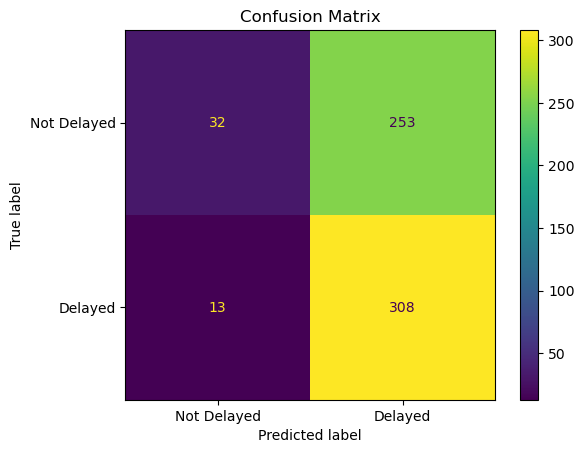

In [91]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_final)

# Display the confusion matrix
ConfusionMatrixDisplay(cm, display_labels=['Not Delayed', 'Delayed']).plot()
plt.title('Confusion Matrix')
plt.show()

Based on the confusion matrix above, with label "Delayed" is coded as 0 and "Not Delayed" is coded as 1, the matrix can be interpreted as follows:

* True Negative (TN): 32 - The number of actual "Not Delayed" cases that were correctly predicted as "Not Delayed".
* False Positive (FP): 253 - The number of actual "Not Delayed" cases that were incorrectly predicted as "Delayed".
* False Negative (FN): 13 - The number of actual "Delayed" cases that were incorrectly predicted as "Not Delayed".
* True Positive (TP): 308 - The number of actual "Delayed" cases that were correctly predicted as "Delayed".

In [92]:
# Generate classification report
report = classification_report(y_test, y_pred_final, target_names=['Delayed', 'Not Delayed'])
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

     Delayed       0.71      0.11      0.19       285
 Not Delayed       0.55      0.96      0.70       321

    accuracy                           0.56       606
   macro avg       0.63      0.54      0.45       606
weighted avg       0.63      0.56      0.46       606



The model has high precision but lower recall for the "Delayed Service" class, meaning it's good at correctly identifying "Delayed Service" but misses a significant number of them. For the "Not Delayed" class, the model has high recall but low precision, meaning it identifies most of the "Not Delayed" but also has a lot of false positives.

The F1-Score for "Delayed" is low at 0.19, indicating room for improvement, especially in balancing precision and recall for the "Delayed" class.


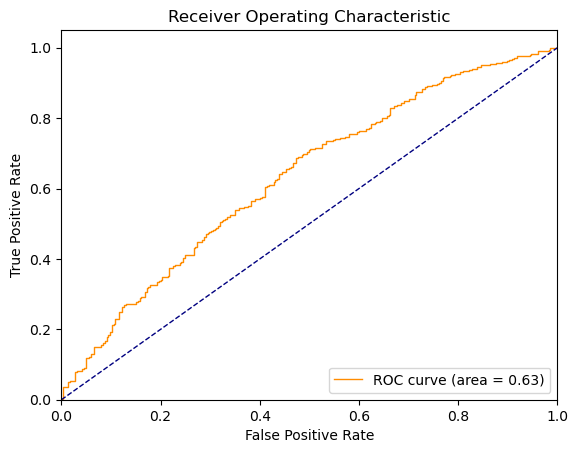

In [93]:
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

The ROC curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings. The area under the curve (AUC) quantifies the overall ability of the model to discriminate between the positive and negative classes.

The model has an AUC of 0.63, which means it has moderate ability to distinguish between the positive and negative classes. The trade-off involved is that in order to achieve a high recall (True Positive Rate), the model will also yield a high False Positive Rate.

Ideally, we want a model that has a high recall (it captures most of the positive instances) and a low Positive Rate(it doesn't flag many negative instances as positive). This would correspond to an AUC-ROC close to 1

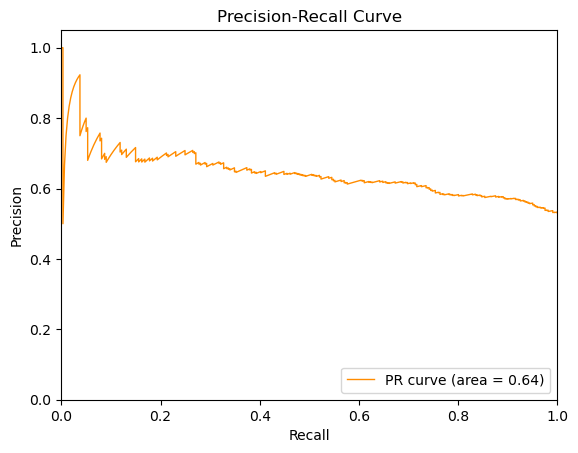

In [94]:
# Compute the precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

# Compute the area under the precision-recall curve
pr_auc = auc(recall, precision)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=1, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.show()

The PR curve plots the trade-off between precision and recall at various threshold settings. In the context of imbalanced datasets, the AUC-PR can provide a more informative picture of model performance than AUC-ROC, especially when the positive class (minority class) is of greater interest. In an ideal scenario, we would want the AUC-PR to be closer to 1, which would mean that the model has high precision and high recall.

The area under the Precision-Recall curve (AUC-PR) of 0.64 indicates that that the model struggles to achieve a good balance between precision and recall. In another words, The model is quite good at identifying most of the actual Delayed Service (high recall), but it also incorrectly flags many patients who would have served promptly i.e without delay(lower precision).